In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## 1. Introduction

In this notebook, we will create a preprocessing and feature engineering pipeline with [Rapids cuDF](https://github.com/rapidsai/cudf) and [Merlin NVTabular](https://github.com/NVIDIA/NVTabular) libraries to prepare our dataset for session-based recommendation model training. 

NVTabular is a feature engineering and preprocessing library for tabular data that is designed to easily manipulate terabyte scale datasets and train deep learning (DL) based recommender systems.

Our main goal is to create session-based features. In order to do that, we are going to perform the following:

- Categorify categorical features with `Categorify()` op
- Create temporal features with a `user-defined custom` op and `Lambda` op
- Transform continuous features using `Log` and `Normalize` ops
- Group all these features together at the session level sorting the interactions by time with `Groupby`
- Finally export the preprocessed datasets to parquet files by hive-partitioning.

### 1.1. Dataset

In our hands-on exercise notebooks we are going to use a subset of the publicly available [eCommerce dataset](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). The ecommeerce behavior data contains 7 months of data (from October 2019 to April 2020) from a large multi-category online store. Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

Data collected by Open CDP project and the source of the dataset is [REES46 Marketing Platform](https://rees46.com/).

## 2. Import Libraries

In [3]:
import os

import numpy as np 
import pandas as pd 
import cupy as cp
import glob

import cudf
import cupy
import nvtabular as nvt
from nvtabular import ColumnSelector

## 3. Set up Input and Output Data Paths

In [4]:
# define some information about where to get our data
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", "/data/")
OUTPUT_DATA_DIR = os.environ.get("OUTPUT_DATA_DIR", INPUT_DATA_DIR + "output")

## 4. Read the Parquet file

We already performed certain preprocessing steps on the first month (Oct-2019) of the raw dataset in the `01-preprocess` notebook: <br>

- we created `event_time_ts` column from `event_time` column which shows the time when event happened at (in UTC).
- we created `prod_first_event_time_ts` column which indicates the timestamp that an item was seen first time.
- we removed the rows where the `user_session` is Null. As a result, 2 rows were removed.
- we categorified the `user_session` column, so that it now has only integer values.
- we removed consequetively repeated (user, item) interactions. For example, an original session with `[1, 2, 4, 1, 2, 2, 3, 3, 3]` product interactions has become `[1, 2, 4, 1, 2, 3]` after removing the repeated interactions on the same item within the same session.

Even though the original dataset contains 7 months data files, we are going to use the first seven days of the `Oct-2019.csv` ecommerce dataset. We use cuDF to read the parquet file. 

In [3]:
%%time
df = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, 'Oct-2019.parquet')) 
df.head()

CPU times: user 650 ms, sys: 308 ms, total: 959 ms
Wall time: 983 ms


,user_session,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_ts,prod_first_event_time_ts
0,197,view,12300705,2053013556311359947,construction.tools.drill,<NA>,79.78,513371687,1570373382,1569905277
1,197,view,12300621,2053013556311359947,construction.tools.drill,<NA>,71.82,513371687,1570373453,1569905174
2,197,view,12300747,2053013556311359947,construction.tools.drill,kolner,65.89,513371687,1570373484,1569903299
3,197,view,12301303,2053013556311359947,construction.tools.drill,kolner,96.67,513371687,1570373530,1570030847
4,197,view,12300061,2053013556311359947,construction.tools.drill,bosch,82.76,513371687,1570373559,1569898066


In [4]:
df.shape

(6390928, 10)

Let's check if there is any column with nulls.

In [5]:
df.isnull().any()

user_session                False
event_type                  False
product_id                  False
category_id                 False
category_code                True
brand                        True
price                       False
user_id                     False
event_time_ts               False
prod_first_event_time_ts    False
dtype: bool

We see that `'category_code', 'brand'` columns have null values, and in the following cell we are going to fill these nulls with via categorify op, and then all categorical columns will be encoded to continuous integers. Note that we also add `1` after we categorify the categorical columns, the reason for that we want the encoded null values to start from `1` instead of `0` because we reserve `0` for padding the seqeunce features.

## 5. Initialize NVTabular Workflow

### 5.1. Categorical Features Encoding


In [6]:
# categorify features 
cat_feats = ['user_session', 'category_code', 'brand', 'user_id', 'product_id', 'category_id', 'event_type'] >> nvt.ops.Categorify() >> nvt.ops.LambdaOp(lambda col: col +1)

### 5.2. Extract Temporal Features

In [7]:
# create time features
sessionTs = ['event_time_ts']

sessionTime = (
    sessionTs >> 
    nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='s')) >> 
    nvt.ops.Rename(name = 'event_time_dt')
)

sessionTime_weekday = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.weekday) >> 
    nvt.ops.Rename(name ='et_dayofweek')
)

Now let's create cycling features from the `sessionTime_weekday` column. We would like to use the temporal features (hour, day of week, month, etc.) inherently cylical characteristic. We represent the day of week as a cycling feature, so that it can be represented in a continuous space (sine and cosine). That way, the difference between the representation of two different days is the same, in other words, with cyclical features we can convey closeness between data. You can read more about it [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/).

In [8]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [9]:
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(name = 'et_dayofweek_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(name = 'et_dayofweek_cos')

### 5.2.1 Add Product Recency feature

- Let's define a custom op to calculate product recency in days

In [10]:
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            item_first_timestamp = gdf['prod_first_event_time_ts']
            delta_days = (col - item_first_timestamp) / (60*60*24)
            gdf[column + "_age_days"] = delta_days * (delta_days >=0)
        return gdf
            
    def output_column_names(self, columns):
        return ColumnSelector([column + "_age_days" for column in columns])

    def dependencies(self):
        return ["prod_first_event_time_ts"]
    
    
recency_features = ['event_time_ts'] >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='product_recency_days_log_norm')

In [11]:
time_features = (
    sessionTime +
    sessionTime_weekday +
    weekday_sin +
    weekday_cos +
    recency_features_norm
)

We can visualize our workflow graph from a feature columngroup object.

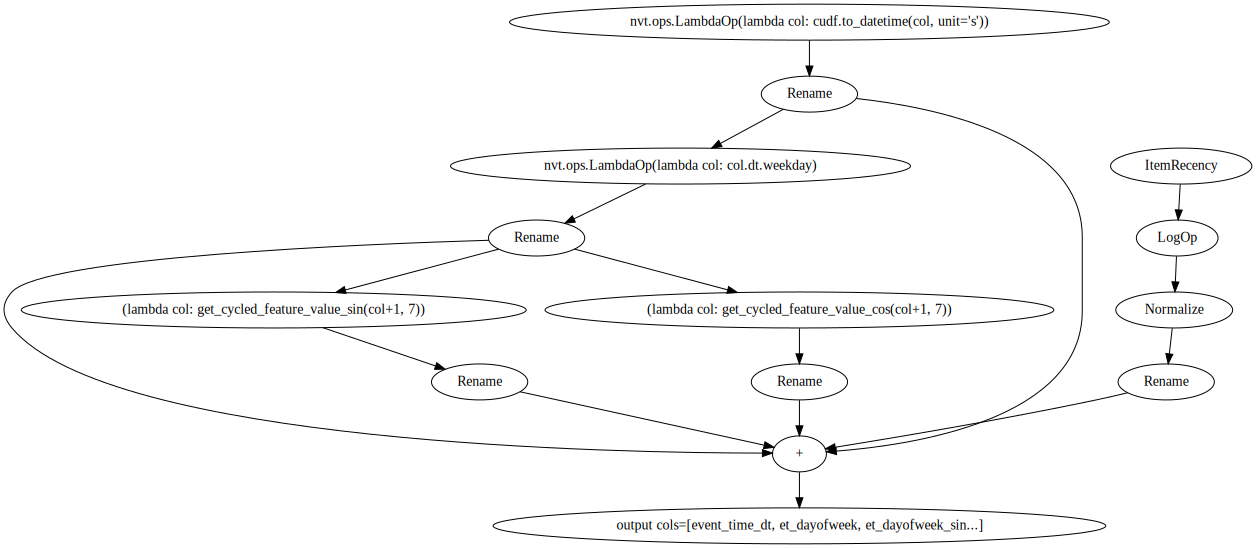

In [12]:
time_features.graph

### 5.4. Normalize Continuous Features¶

In [13]:
# Smoothing price long-tailed distribution
price_log = ['price'] >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='price_log_norm')

In [14]:
# Relative Price to the average price for the category_id
def relative_price_to_avg_categ(col, gdf):
    epsilon = 1e-5
    col = ((gdf['price'] - col) / (col + epsilon)) * (col > 0).astype(int)
    return col
    
avg_category_id_pr = ['category_id'] >> nvt.ops.JoinGroupby(cont_cols =['price'], stats=["mean"]) >> nvt.ops.Rename(name='avg_category_id_price')
relative_price_to_avg_category = avg_category_id_pr >> nvt.ops.LambdaOp(relative_price_to_avg_categ, dependency=['price']) >> nvt.ops.Rename(name="relative_price_to_avg_categ_id")

### 5.5. Grouping interactions into sessions¶

#### Aggregate by session id (create sequence as type of array)

In [15]:
groupby_feats = ['event_time_ts', 'user_session'] + cat_feats + time_features + price_log + relative_price_to_avg_category

In [16]:
# Define Groupby Workflow
groupby_features = groupby_feats >> nvt.ops.Groupby(
    groupby_cols=["user_session"], 
    sort_cols=["event_time_ts"],
    aggs={
        'user_id': ['first'],
        'product_id': ["list", "count"],
        'category_code': ["list"],  
        'event_type': ["list"], 
        'brand': ["list"], 
        'category_id': ["list"], 
        'event_time_ts': ["first"],
        'event_time_dt': ["first"],
        'et_dayofweek_sin': ["list"],
        'et_dayofweek_cos': ["list"],
        'price_log_norm': ["list"],
        'relative_price_to_avg_categ_id': ["list"],
        'product_recency_days_log_norm': ["list"]
        },
    name_sep="-")

- Select columns which are not list

In [17]:
groupby_features_nonlist = [x for x in groupby_features.output_columns.names if '-list' not in x]
groupby_features_nonlist

['event_time_dt-first',
 'user_session',
 'event_time_ts-first',
 'product_id-count',
 'user_id-first']

In [18]:
SESSIONS_MAX_LENGTH = 20 
MINIMUM_SESSION_LENGTH = 2

We trim the features in sequence in each session according to sessions_max_length param which is set as 20 in our example.

In [19]:
groupby_features_trim = ((groupby_features - groupby_features_nonlist)) >> nvt.ops.ListSlice(0,SESSIONS_MAX_LENGTH) >> nvt.ops.Rename(postfix = '_seq')

/nvtabular/nvtabular/workflow/node.py:45: FutureWarning: The `["a", "b", "c"] >> ops.Operator` syntax for creating a `ColumnGroup` has been deprecated in NVTabular 21.09 and will be removed in a future version.
  warnings.warn(


- Create a `day_index` column in order to partition sessions by day when saving the parquet files.

In [20]:
# calculate session day index based on 'timestamp-first' column
day_index = ((groupby_features['event_time_dt-first'])  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(f = lambda col: "day_index")
)

- Select certain columns to be used in model training

In [21]:
selected_features = groupby_features[groupby_features_nonlist] + groupby_features_trim + day_index

- Filter out the session that have sesion size 1.

In [22]:
remove_cols = ['event_time_dt-first', 'event_time_ts-first']

In [23]:
filtered_sessions = (selected_features - remove_cols) >> nvt.ops.Filter(f=lambda df: df["product_id-count"] >= MINIMUM_SESSION_LENGTH)

- Initialize the NVTabular dataset object and workflow graph.

NVTabular's preprocessing and feature engineering workflows are directed graphs of operators. When we initialize an NVTabular Workflow with our pipeline, workflow organizes the input and output columns.

In [25]:
dataset = nvt.Dataset(df)

workflow = nvt.Workflow(filtered_sessions)
workflow.fit(dataset)
sessions_gdf = workflow.transform(dataset).to_ddf()

/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Above, we created an NVTabular Dataset object using our input dataset. Then, we calculate statistics for this workflow on the input dataset, i.e. on our training set, using the workflow.fit() method so that our Workflow can use these stats to transform any given input.

Let's print the head of our preprocessed dataset

In [26]:
sessions_gdf.head(2)

,user_session,product_id-count,user_id-first,price_log_norm-list_seq,product_recency_days_log_norm-list_seq,category_code-list_seq,et_dayofweek_sin-list_seq,event_type-list_seq,product_id-list_seq,category_id-list_seq,relative_price_to_avg_categ_id-list_seq,et_dayofweek_cos-list_seq,brand-list_seq,day_index
0,2,779,4,"[-0.60630524, -0.59222364, -0.5865736, -0.9532...","[-2.2660873, -2.2660873, -2.265767, -2.2660873...","[1, 1, 1, 1, 1, 12, 12, 12, 12, 12, 12, 12, 12...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19064, 52057, 13290, 11446, 15835, 879, 633, ...","[3, 3, 3, 3, 3, 17, 17, 17, 17, 17, 17, 17, 17...","[0.03519272311423613, 0.05391071556495246, 0.0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[171, 120, 231, 392, 562, 20, 9, 20, 295, 143,...",1
1,3,316,59,"[0.7637999, 0.40693888, 0.25858778, 0.01305765...","[-0.85815144, -0.9379316, -1.0066851, -0.93632...","[1, 17, 17, 15, 1, 1, 17, 31, 17, 17, 17, 17, ...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[252, 2801, 5399, 1074, 252, 355, 327, 319, 34...","[234, 36, 36, 30, 234, 52, 36, 48, 36, 36, 36,...","[0.0006990395471891284, -0.04875344340417949, ...","[-0.90096927, -0.90096927, -0.90096927, -0.900...","[1, 1, 1, 1, 1, 50, 1, 1, 36, 1, 1, 36, 50, 1,...",2


In [28]:
workflow.output_schema.column_names

['user_session',
 'product_id-count',
 'user_id-first',
 'price_log_norm-list_seq',
 'product_recency_days_log_norm-list_seq',
 'category_code-list_seq',
 'et_dayofweek_sin-list_seq',
 'event_type-list_seq',
 'product_id-list_seq',
 'category_id-list_seq',
 'relative_price_to_avg_categ_id-list_seq',
 'et_dayofweek_cos-list_seq',
 'brand-list_seq',
 'day_index']

- Save workflow to load later on

In [29]:
workflow.save('workflow_ecommerce_etl')

In this step we can serialize our nvtabular model, and generate model config files to be able to serve our model to [Triton Inference Server](https://github.com/triton-inference-server/server).

In [29]:
from nvtabular.inference.triton import generate_nvtabular_model
generate_nvtabular_model(
    workflow=workflow,
    name='model_nvt',
    output_path='/workspace/TF4Rec/models/model_nvt/',
)

## 6. Exporting data

- Export dataset to parquet, partioned by the session day_idx

When our Workflow transforms our dataset, we also save the results out to parquet files for fast reading at train time. 

In [32]:
PARTITION_COL = 'day_index'

# Convert to a Dataset and write out hive-partitioned data to disk
workflow.transform(dataset).to_parquet(OUTPUT_DATA_DIR, partition_on=[PARTITION_COL])

In [43]:
!ls $OUTPUT_DATA_DIR

 _metadata     'day_index=2'  'day_index=4'  'day_index=6'
'day_index=1'  'day_index=3'  'day_index=5'  'day_index=7'


### 6.1. Converting to the Transformers4Rec dir structure and splitting dataset¶


In [10]:
OUTPUT_FOLDER = os.path.join(INPUT_DATA_DIR, 'sessions_by_day')
!mkdir -p $OUTPUT_FOLDER

In this section we are going to create a folder structure as shown below. As we explained above, this is just to structure parquet files so that it would be easier to do incremental training and evaluation.

```
/output/sessions_by_day/
|-- 0001
|   |-- train.parquet
|   |-- valid.parquet
|   |-- test.parquet

|-- 0002
|   |-- train.parquet
|   |-- valid.parquet
|   |-- test.parquet
```

In [44]:
days_folders = [f for f in sorted(os.listdir(OUTPUT_DATA_DIR)) if f.startswith(PARTITION_COL)]
for day_folder in days_folders:
    df = cudf.read_parquet(os.path.join(OUTPUT_DATA_DIR, day_folder))
    out_folder = os.path.join(OUTPUT_FOLDER, day_folder.replace('day_index=', ''))
    os.makedirs(out_folder, exist_ok=True)
    cp.random.seed(1)
    random_values = cp.random.rand(len(df))
    # Extracts 80% , 10%  and 10% for train, valid and test set, respectively. 
    train_set = df[random_values <= 0.80]
    train_set.to_parquet(os.path.join(out_folder, 'train.parquet'))
    
    valid_set = df[(random_values > 0.80) &  (random_values < 0.90)]
    valid_set.to_parquet(os.path.join(out_folder, 'valid.parquet'))
    
    test_set = df[random_values >= 0.90]
    test_set.to_parquet(os.path.join(out_folder, 'test.parquet'))

## 7. Wrap Up 

That's it! we finished our first task. We reprocessed our dataset and created new features to train a session-based recommendation model. Please run the cell below to shut down the kernel before moving on to the next notebook.

In [35]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)